In [3]:
import math
from functools import partial, reduce

import pandas as pd
import geopandas as gpd
import pyrosm
import pyproj
from shapely.ops import nearest_points, transform
from shapely.geometry import Polygon, Point

import contextily
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

In [2]:
# Читаем файл
df = pd.read_csv('train_test/train.csv', index_col=[0]).dropna()
# Добавляем геометрические точки по долготе и широте
df['geometry'] = [Point(xy) for xy in zip(df.long, df.lat)]
df['coordinates'] = [(xy) for xy in zip(df.long, df.lat)]
# Трансформируем фрейм в геофрейм
train = gpd.GeoDataFrame(df)
train.crs = 'epsg:4326'

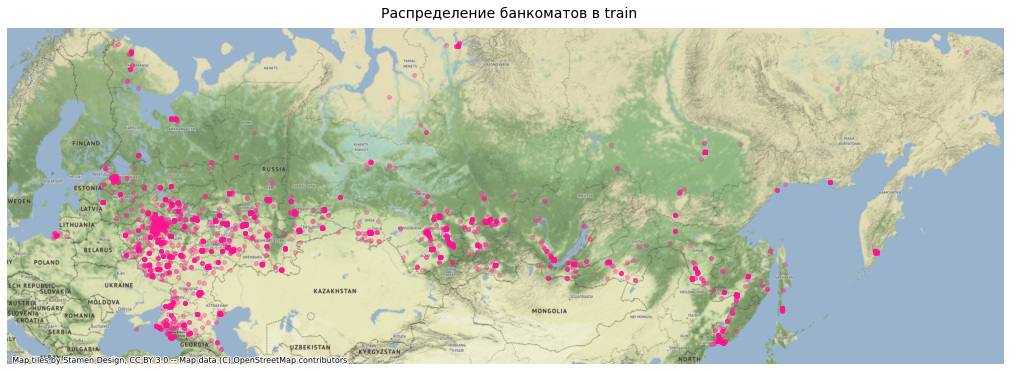

In [3]:
plot_data = train['geometry'].to_crs(epsg = 3857)
ax = plot_data.plot(markersize = 15, color = 'deeppink', alpha = 0.3, figsize=(18, 10))
contextily.add_basemap(ax)
plt.title('Распределение банкоматов в train', size = 14, pad = 10)
plt.axis('off')
plt.show()

In [4]:
# Если хочется интерактива
# train.explore(color='deeppink')

In [4]:
# Список OSM тэгов
tag_list = [
    {'subway': True},
    {'public_transport': ['stop_position']},
    {'government': ['administrative']},
    {'amenity': ['college', 'university']},
    {'amenity': ['school']},
    {'amenity': ['kindergarten', 'childcare']},
    {'office': ['company']},
    {'amenity': ['cafe', 'fast_food', 'bar', 'pub', 'canteen']}
]

# Human-readable имена тегов 
tag_names = [
    'subway',
    'bus_stop',
    'gov_building',
    'college',
    'school',
    'kgarden',
    'office',
    'food'
]

In [5]:
help(pyrosm.OSM.__init__)
russia_dump = pyrosm.get_data('russia',directory='enrichment')
russia_osm = pyrosm.OSM(russia_dump)
print("Type of 'osm' instance: ", type(russia_osm))

Help on function __init__ in module pyrosm.pyrosm:

__init__(self, filepath, bounding_box=None)
    Initialize self.  See help(type(self)) for accurate signature.

Type of 'osm' instance:  <class 'pyrosm.pyrosm.OSM'>


In [6]:
def get_infrastructure(osm_obj, tag_list, tag_names):
    
    '''
    Возвращает словарь геофреймов с объектами инфраструктуры
    
    Keyword arguments:
    osm_obj -- объект OSM откудя тянем информацию по тегам
    tag_list -- лист со словарями тегов инфраструктуры
    tag_names -- human-readable ключ типа инфратсруктуры
    '''
    
    # инициализируем слвоарь аутпутов
    output = {}
    # аргументы для .get_data_by_custom_criteria
    node_filter = {'keep_ways': False, 'keep_relations': False} 
    
    # итерируемся над тегами и вытаскиваем информацию из OSM объекта
    for name, tag in zip(tag_names, tag_list):
        output[name] = osm_obj.get_data_by_custom_criteria(
            custom_filter=tag, **node_filter)
        print(name, ": done")
        
    return output

In [ ]:
russia_infrastructure = get_infrastructure(russia_osm, tag_list, tag_names)

In [ ]:
def dist_to_nearest_neighbour(df, epsg = 3857):
    
    '''
    Считает минимальное расстояние до ближайшего соседнего банкомата
    
    df -- геофрейм с данными о банкоматах
    epsg -- желаемая проекция геофрейма (default:Pseudo-Mercator)
    '''
    
    df = df.copy().to_crs(epsg)
    df['nearest_atm'] = None
    for index, row in df.iterrows():
        point = row['geometry']
        multipoint = df.drop(index, axis=0)['geometry'].unary_union
        _, nearest_geom = nearest_points(point, multipoint)
        df.loc[index, 'nearest_atm'] = nearest_geom.distance(point)
        
    return df

In [ ]:
russia_data = dist_to_nearest_neighbour(russia_data)


In [ ]:
def dist_to_nearest_obj(atm, obj, epsg = 3857):
    
    '''
    Считает минимальное расстояние между объектами инфраструктры и банкоматом
    
    atm -- строчка из геофрейма с банкоматами
    infrastracture -- геофрейм с информацией об инфратсруктуре
    epsg -- желаемая проекция инфраструктурного геофрейма (default:Pseudo-Mercator)
    '''
    
    dist = min(obj.to_crs(epsg = epsg).distance(atm))
    return dist

In [ ]:
for (name, infr) in russia_infrastructure.items():
    russia_data['nearest_{}'.format(name)] = \
        russia_data['geometry'].apply(dist_to_nearest_obj, obj=infr)

In [ ]:
def points_in_buffer(point_df, poly_df, name, m=250):

    '''
    Считает количество точек из points_df в каждом полигоне из poly_df

    point_df -- Геофрейм с объектами инфраструктуры
    poly_df -- Геофрейм с омновной информацией по банкоматам
    m -- Радиус для буффера
    '''

    # Считаем буффер
    poly_df['{}m_buffer'.format(m)] = poly_df['coordinates'].apply(
        geodesic_point_buffer, m=m
    )
    # Меняем геометрию с точек на полигоны (буфферы)
    poly_df.set_geometry('{}m_buffer'.format(m), inplace=True)

    # Считаем количество точек из point_df в каждом полигоне из poly_df
    pts_in_poly = gpd.sjoin(point_df, poly_df, how='left')
    pts_in_poly['const'] = 1
    counter = pts_in_poly.groupby('index_right')['const'].sum()
    counter.name = '{}_in_{}m'.format(name, m)

    # Чистим фрейм от колонки буффера и возвращаем исходную геометрию
    poly_df.drop('{}m_buffer'.format(m), axis=1, inplace=True)
    poly_df.set_geometry('geometry', inplace=True)

    return counter

In [ ]:
counter_list = []
for (name, infr) in russia_infrastructure.items():
    counter_list.append(points_in_buffer(infr, russia_data, name, 250))
    
dfs = [russia_data] + counter_list

In [ ]:
df_final = reduce(lambda left, right: left.join(right), dfs).fillna(0)

In [ ]:
df_final.explore()